In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df

,id,rfid_tag,checkin_time,checkout_time,note,date
0,203628,BA6379D,NaN,NaN,libur,2025-11-23
1,203629,BB39389D,NaN,NaN,libur,2025-11-23
2,203630,AB33A9D,NaN,NaN,libur,2025-11-23
3,203631,ABEA3B9D,NaN,NaN,libur,2025-11-23
4,203632,AB7A3C9D,NaN,NaN,libur,2025-11-23
...,...,...,...,...,...,...
159529,39969,DBE089D,NaN,NaN,alpa,2025-08-04
159530,39970,4B23E9D,NaN,NaN,alpa,2025-08-04
159531,39971,CB8689D,NaN,NaN,alpa,2025-08-04
159532,39972,7BC34D9D,NaN,NaN,alpa,2025-08-04


In [3]:
df.head()

,id,rfid_tag,checkin_time,checkout_time,note,date
0,203628,BA6379D,NaN,NaN,libur,2025-11-23
1,203629,BB39389D,NaN,NaN,libur,2025-11-23
2,203630,AB33A9D,NaN,NaN,libur,2025-11-23
3,203631,ABEA3B9D,NaN,NaN,libur,2025-11-23
4,203632,AB7A3C9D,NaN,NaN,libur,2025-11-23


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159534 entries, 0 to 159533
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159534 non-null  int64 
 1   rfid_tag       159534 non-null  object
 2   checkin_time   66293 non-null   object
 3   checkout_time  40519 non-null   object
 4   note           102503 non-null  object
 5   date           159534 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.3+ MB


In [5]:
# encode rfid tag
df['rfid_tag'] = df['rfid_tag'].astype('category').cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159534 entries, 0 to 159533
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159534 non-null  int64 
 1   rfid_tag       159534 non-null  int16 
 2   checkin_time   66293 non-null   object
 3   checkout_time  40519 non-null   object
 4   note           102503 non-null  object
 5   date           159534 non-null  object
dtypes: int16(1), int64(1), object(4)
memory usage: 6.4+ MB


In [6]:
tag = df["rfid_tag"].value_counts()

In [7]:
tag

rfid_tag
1017    112
244     112
1304    112
299     112
1118    112
       ... 
784      12
491      12
1131     12
490      12
683      10
Name: count, Length: 1491, dtype: int64

In [8]:
tag.sort_values(inplace=True, ascending=False)

In [9]:
tag

rfid_tag
1017    112
643     112
951     112
921     112
715     112
       ... 
789      12
496      12
877      12
492      12
683      10
Name: count, Length: 1491, dtype: int64

In [10]:
# Preprocess waktu, note, dan date menjadi fitur numerik untuk training
# Mengasumsikan df sudah ada di notebook

# parse tanggal
df['date_dt'] = pd.to_datetime(df['date'], errors='coerce')

# gabungkan date + time supaya time-only juga bisa diparse; kosong -> coerce ke NaT
df['checkin_dt'] = pd.to_datetime(
    df['date'].astype(str).str.strip().fillna('') + ' ' + df['checkin_time'].fillna('').astype(str).str.strip(),
    errors='coerce'
)
df['checkout_dt'] = pd.to_datetime(
    df['date'].astype(str).str.strip().fillna('') + ' ' + df['checkout_time'].fillna('').astype(str).str.strip(),
    errors='coerce'
)

# ekstrak komponen waktu dan flag missing
df['checkin_hour'] = df['checkin_dt'].dt.hour
df['checkin_minute'] = df['checkin_dt'].dt.minute
df['checkin_missing'] = df['checkin_dt'].isna().astype(int)

df['checkout_hour'] = df['checkout_dt'].dt.hour
df['checkout_minute'] = df['checkout_dt'].dt.minute
df['checkout_missing'] = df['checkout_dt'].isna().astype(int)

# proses note -> kategorikal numeric
df['note_filled'] = df['note'].fillna('missing')
df['note_label'] = df['note_filled'].astype('category').cat.codes

# fitur tambahan dari date
df['date_weekday'] = df['date_dt'].dt.weekday  # 0 = Monday
df['date_day'] = df['date_dt'].dt.day
df['date_month'] = df['date_dt'].dt.month
# ordinal tanggal (untuk model yang membutuhkan kontinuitas)
df['date_ordinal'] = df['date_dt'].apply(lambda x: x.toordinal() if pd.notna(x) else -1)

# siapkan DataFrame fitur siap-train (pilih kolom sesuai kebutuhan model)
feature_cols = [
    'rfid_tag',
    'checkin_hour', 'checkin_minute', 'checkin_missing',
    'checkout_hour', 'checkout_minute', 'checkout_missing',
    'note_label',
    'date_weekday', 'date_day', 'date_month', 'date_ordinal'
]
features = df[feature_cols].copy()

# isi nilai yang masih NaN dengan -1 agar model non-numeric tidak error
features = features.fillna(-1)

# contoh: lihat ringkasan fitur
features.dtypes, features.head()

(rfid_tag              int16
 checkin_hour        float64
 checkin_minute      float64
 checkin_missing       int32
 checkout_hour       float64
 checkout_minute     float64
 checkout_missing      int32
 note_label             int8
 date_weekday          int32
 date_day              int32
 date_month            int32
 date_ordinal          int64
 dtype: object,
    rfid_tag  checkin_hour  checkin_minute  checkin_missing  checkout_hour  \
 0      1017           0.0             0.0                0            0.0   
 1      1035           0.0             0.0                0            0.0   
 2       894           0.0             0.0                0            0.0   
 3       951           0.0             0.0                0            0.0   
 4       921           0.0             0.0                0            0.0   
 
    checkout_minute  checkout_missing  note_label  date_weekday  date_day  \
 0              0.0                 0           1             6        23   
 1          

In [11]:
df.drop(columns=["checkin_time", "checkout_time", "note", "date"], inplace=True)

In [12]:
df.head()

,id,rfid_tag,date_dt,checkin_dt,checkout_dt,checkin_hour,checkin_minute,checkin_missing,checkout_hour,checkout_minute,checkout_missing,note_filled,note_label,date_weekday,date_day,date_month,date_ordinal
0,203628,1017,2025-11-23,2025-11-23,2025-11-23,0.0,0.0,0,0.0,0.0,0,libur,1,6,23,11,739578
1,203629,1035,2025-11-23,2025-11-23,2025-11-23,0.0,0.0,0,0.0,0.0,0,libur,1,6,23,11,739578
2,203630,894,2025-11-23,2025-11-23,2025-11-23,0.0,0.0,0,0.0,0.0,0,libur,1,6,23,11,739578
3,203631,951,2025-11-23,2025-11-23,2025-11-23,0.0,0.0,0,0.0,0.0,0,libur,1,6,23,11,739578
4,203632,921,2025-11-23,2025-11-23,2025-11-23,0.0,0.0,0,0.0,0.0,0,libur,1,6,23,11,739578


In [13]:
# ubah note_filled menjadi ordered categorical berdasarkan frekuensi,
# lalu update kolom numerik note_label dan sinkronkan ke features
order = df['note_filled'].value_counts().index.tolist()
df['note_filled'] = pd.Categorical(df['note_filled'], categories=order, ordered=True)
df['note_label'] = df['note_filled'].cat.codes

# jika DataFrame fitur ada, sinkronkan kolom note_label
if 'features' in globals() and 'note_label' in features.columns:
    features['note_label'] = df['note_label']

# tampilkan pemeriksaan singkat
df[['note_filled', 'note_label']].head()

,note_filled,note_label
0,libur,1
1,libur,1
2,libur,1
3,libur,1
4,libur,1


In [14]:
df.drop(columns=["note_filled"], inplace=True)

In [15]:
df.describe()

,id,rfid_tag,date_dt,checkin_dt,checkout_dt,checkin_hour,checkin_minute,checkin_missing,checkout_hour,checkout_minute,checkout_missing,note_label,date_weekday,date_day,date_month,date_ordinal
count,159534.000000,159534.000000,159534,93241,119015,93241.0,93241.0,159534.000000,119015.0,119015.0,159534.000000,159534.000000,159534.000000,159534.000000,159534.000000,159534.000000
mean,123108.199211,749.372115,2025-09-29 10:32:55.944939776,2025-09-26 22:09:47.561265920,2025-09-27 06:04:21.526698240,0.0,0.0,0.415542,0.0,0.0,0.253983,1.048403,3.003404,15.440709,9.467543,739523.439536
min,38493.000000,0.000000,2025-08-04 00:00:00,2025-08-04 00:00:00,2025-08-04 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,8.000000,739467.000000
25%,81745.250000,369.000000,2025-09-02 00:00:00,2025-08-28 00:00:00,2025-08-28 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,8.000000,9.000000,739496.000000
50%,123797.500000,752.000000,2025-09-30 00:00:00,2025-09-27 00:00:00,2025-09-27 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,3.000000,15.000000,9.000000,739524.000000
75%,164733.750000,1122.000000,2025-10-27 00:00:00,2025-10-26 00:00:00,2025-10-27 00:00:00,0.0,0.0,1.000000,0.0,0.0,1.000000,2.000000,5.000000,22.000000,10.000000,739551.000000
max,205118.000000,1490.000000,2025-11-23 00:00:00,2025-11-23 00:00:00,2025-11-23 00:00:00,0.0,0.0,1.000000,0.0,0.0,1.000000,3.000000,6.000000,31.000000,11.000000,739578.000000
std,48054.979176,432.233002,NaN,NaN,NaN,0.0,0.0,0.492817,0.0,0.0,0.435290,0.936556,1.999068,8.413137,1.074630,32.300025


In [16]:
df.drop(columns=["checkin_hour", "checkin_minute", "checkout_hour", "checkout_minute"], inplace=True)

In [17]:
df.head()

,id,rfid_tag,date_dt,checkin_dt,checkout_dt,checkin_missing,checkout_missing,note_label,date_weekday,date_day,date_month,date_ordinal
0,203628,1017,2025-11-23,2025-11-23,2025-11-23,0,0,1,6,23,11,739578
1,203629,1035,2025-11-23,2025-11-23,2025-11-23,0,0,1,6,23,11,739578
2,203630,894,2025-11-23,2025-11-23,2025-11-23,0,0,1,6,23,11,739578
3,203631,951,2025-11-23,2025-11-23,2025-11-23,0,0,1,6,23,11,739578
4,203632,921,2025-11-23,2025-11-23,2025-11-23,0,0,1,6,23,11,739578


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159534 entries, 0 to 159533
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                159534 non-null  int64         
 1   rfid_tag          159534 non-null  int16         
 2   date_dt           159534 non-null  datetime64[ns]
 3   checkin_dt        93241 non-null   datetime64[ns]
 4   checkout_dt       119015 non-null  datetime64[ns]
 5   checkin_missing   159534 non-null  int32         
 6   checkout_missing  159534 non-null  int32         
 7   note_label        159534 non-null  int8          
 8   date_weekday      159534 non-null  int32         
 9   date_day          159534 non-null  int32         
 10  date_month        159534 non-null  int32         
 11  date_ordinal      159534 non-null  int64         
dtypes: datetime64[ns](3), int16(1), int32(5), int64(2), int8(1)
memory usage: 9.6 MB


In [19]:
df_clean = df.drop(columns=["id"])

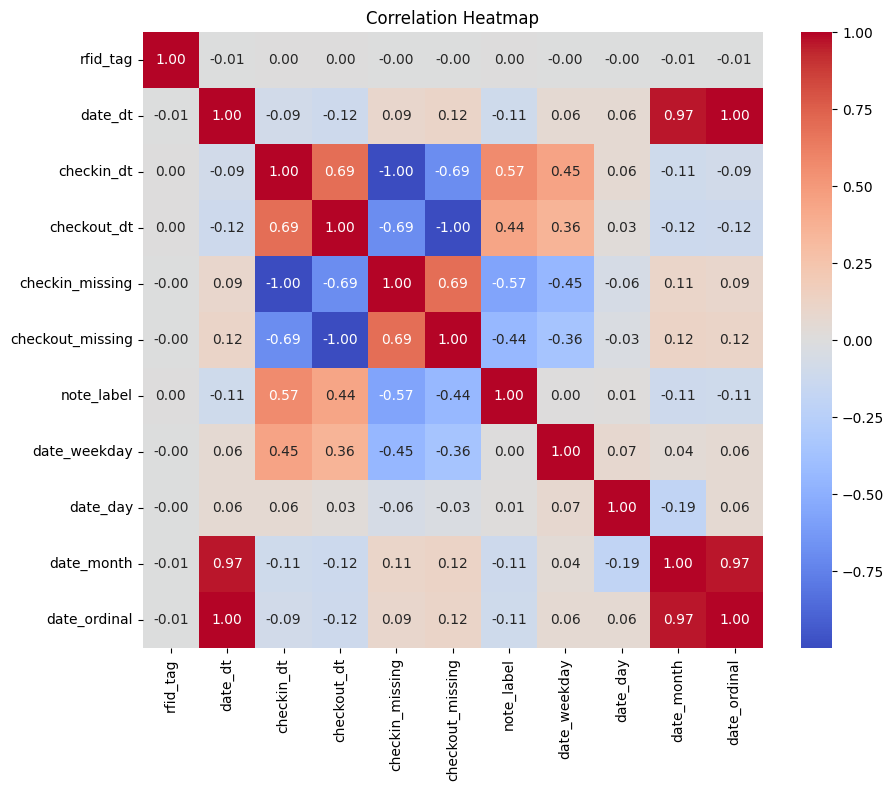

In [20]:
import seaborn as sns

# heatmap of numeric feature correlations
plt.figure(figsize=(10, 8))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

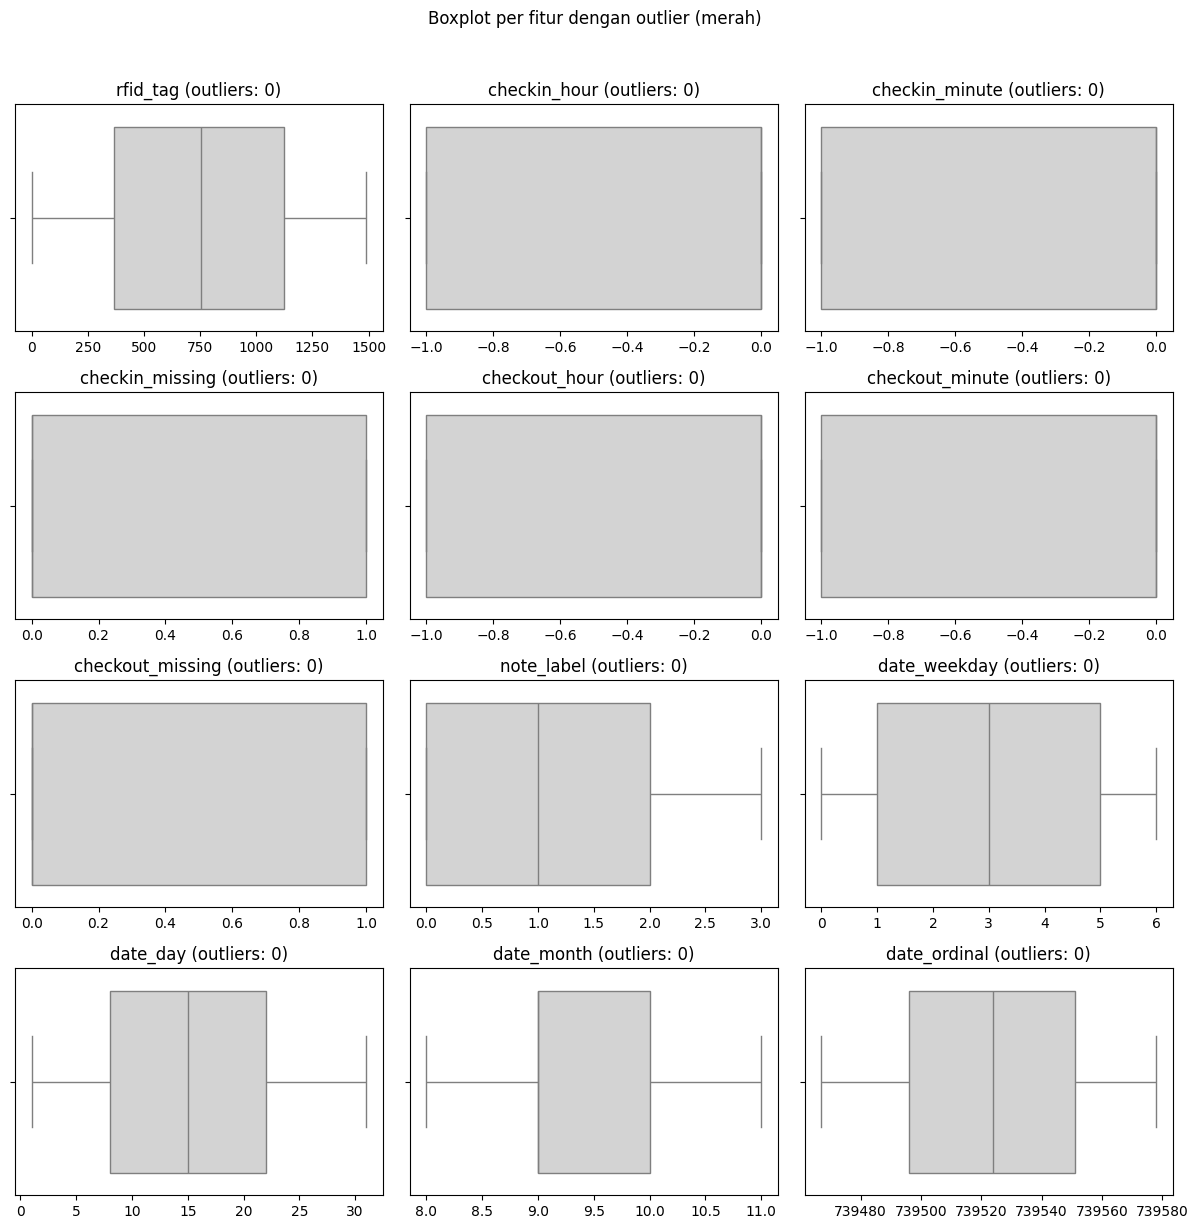

In [22]:
# boxplot + highlight outliers untuk masing-masing fitur numerik di `features`
numeric_cols = features.select_dtypes(include='number').columns.tolist()

n = len(numeric_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    # boxplot
    sns.boxplot(x=features[col], ax=ax, color='lightgray')
    # deteksi outlier (IQR rule)
    q1 = features[col].quantile(0.25)
    q3 = features[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    out = features[(features[col] < lower) | (features[col] > upper)][col]
    # plot outliers sebagai titik merah (jitter untuk visibilitas)
    if not out.empty:
        sns.stripplot(x=out, ax=ax, color='red', size=4, jitter=0.2)
    ax.set_title(f"{col} (outliers: {len(out)})")
    ax.set_xlabel('')

# hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Boxplot per fitur dengan outlier (merah)", y=1.02)
plt.tight_layout()
plt.show()